# MLB Pitching Analytics: Advanced Metrics and Trends (2000–2024)

## Executive Summary
This project analyzes MLB pitching performance from 2000–2024 using the Lahman database.  
After cleaning and enriching the data with advanced sabermetric metrics, I use SQL and Python to explore trends and prepare the dataset for visualization.  
The goal is to evaluate pitcher performance with modern indicators like K/9, BB/9, HR/9, and WHIP, and highlight league-wide pitching trends over the last 25 years.

## Table of Contents
1. Setup  
2. Data Cleaning  
3. Feature Engineering  
4. Database Integration (SQL)  
5. Exploratory Analysis (Python)  
6. Visualization Prep (Tableau)  
7. Documentation  

## 1. Setup

### 1.1 Import Libraries
We import Python libraries for data manipulation, visualization, and database interaction.

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

### 1.2 Load Raw Pitching Data
We load `Pitching.csv` and `People.csv` from the Lahman dataset.  
`Pitching.csv` provides pitching statistics, while `People.csv` provides player names and biographical info.

In [3]:
# Load raw pitching data
pitching = pd.read_csv("../data/lahman_data/Pitching.csv")
people = pd.read_csv("../data/lahman_data/People.csv")

# Preview
pitching.head()


,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,aardsda01,2004,1,SFN,NL,1,0,11,0,0,...,0.0,0,2.0,0,61.0,5,8,0.0,1.0,1.0
1,aardsda01,2006,1,CHN,NL,3,0,45,0,0,...,0.0,1,1.0,0,225.0,9,25,1.0,3.0,2.0
2,aardsda01,2007,1,CHA,AL,2,1,25,0,0,...,3.0,2,1.0,0,151.0,7,24,2.0,1.0,1.0
3,aardsda01,2008,1,BOS,AL,4,2,47,0,0,...,2.0,3,5.0,0,228.0,7,32,3.0,2.0,4.0
4,aardsda01,2009,1,SEA,AL,3,6,73,0,0,...,3.0,2,0.0,0,296.0,53,23,2.0,1.0,2.0


## 2. Data Cleaning
We inspect and filter the dataset to focus on modern MLB pitching (2000 - 2024).
Low-inning pitchers (<30 IP) are removed to avoid small sampling size noise.

In [4]:
# Inspect dataset
pitching.info()
pitching.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52344 entries, 0 to 52343
Data columns (total 30 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   playerID  52344 non-null  object 
 1   yearID    52344 non-null  int64  
 2   stint     52344 non-null  int64  
 3   teamID    52344 non-null  object 
 4   lgID      52212 non-null  object 
 5   W         52344 non-null  int64  
 6   L         52344 non-null  int64  
 7   G         52344 non-null  int64  
 8   GS        52344 non-null  int64  
 9   CG        52344 non-null  int64  
 10  SHO       52344 non-null  int64  
 11  SV        52344 non-null  int64  
 12  IPouts    52344 non-null  int64  
 13  H         52344 non-null  int64  
 14  ER        52344 non-null  int64  
 15  HR        52344 non-null  int64  
 16  BB        52344 non-null  int64  
 17  SO        52344 non-null  int64  
 18  BAOpp     47900 non-null  float64
 19  ERA       52243 non-null  float64
 20  IBB       37766 non-null  fl

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
count,52344.000000,52344.000000,52344.000000,52344.000000,52344.000000,52344.000000,52344.000000,52344.000000,52344.000000,52344.000000,...,37766.000000,52344.000000,51610.000000,52344.000000,52341.000000,52344.000000,52344.000000,33157.000000,33157.000000,32023.000000
mean,1975.986321,1.084938,4.392805,4.392805,23.301773,8.832798,2.713186,0.388526,1.463281,236.289737,...,2.073293,2.505808,2.338345,0.283586,337.034103,6.116403,40.068298,2.404952,2.032874,5.464104
std,39.247168,0.296589,5.591321,4.830395,18.609905,11.976445,6.653379,1.041169,4.944372,248.181833,...,2.630022,3.577917,3.102922,0.724389,347.602941,9.751326,41.653071,3.135957,2.286974,6.122173
min,1871.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1948.000000,1.000000,0.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000,45.000000,...,0.000000,0.000000,0.000000,0.000000,68.000000,0.000000,10.000000,0.000000,0.000000,1.000000
50%,1987.000000,1.000000,2.000000,3.000000,21.000000,2.000000,0.000000,0.000000,0.000000,150.000000,...,1.000000,1.000000,1.000000,0.000000,217.000000,2.000000,25.000000,1.000000,1.000000,3.000000
75%,2009.000000,1.000000,7.000000,7.000000,34.000000,16.000000,2.000000,0.000000,1.000000,356.000000,...,3.000000,3.000000,3.000000,0.000000,511.000000,8.000000,61.000000,4.000000,3.000000,8.000000
max,2024.000000,5.000000,60.000000,48.000000,106.000000,75.000000,75.000000,16.000000,62.000000,2040.000000,...,23.000000,83.000000,54.000000,16.000000,2906.000000,84.000000,519.000000,27.000000,17.000000,47.000000


In [5]:
# Keep modern era data
pitching = pitching[pitching["yearID"] >= 2000]

# Convert IPouts to innings
pitching["IP"] = pitching["IPouts"] / 3

# Remove pitchers with <30 innings
pitching = pitching[pitching["IP"] >= 30]

# Merge with player names
pitching = pitching.merge(
    people[["playerID", "nameFirst", "nameLast"]],
    on="playerID", how="left"
)
pitching["playerName"] = pitching["nameFirst"] + " " + pitching["nameLast"]

pitching.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,BFP,GF,R,SH,SF,GIDP,IP,nameFirst,nameLast,playerName
0,aardsda01,2006,1,CHN,NL,3,0,45,0,0,...,225.0,9,25,1.0,3.0,2.0,53.000000,David,Aardsma,David Aardsma
1,aardsda01,2007,1,CHA,AL,2,1,25,0,0,...,151.0,7,24,2.0,1.0,1.0,32.333333,David,Aardsma,David Aardsma
2,aardsda01,2008,1,BOS,AL,4,2,47,0,0,...,228.0,7,32,3.0,2.0,4.0,48.666667,David,Aardsma,David Aardsma
3,aardsda01,2009,1,SEA,AL,3,6,73,0,0,...,296.0,53,23,2.0,1.0,2.0,71.333333,David,Aardsma,David Aardsma
4,aardsda01,2010,1,SEA,AL,0,6,53,0,0,...,202.0,43,19,7.0,1.0,5.0,49.666667,David,Aardsma,David Aardsma


## 3. Feature Engineering

We calculate advanced sabermetric pitching metrics:
- **K/9**: Strikeouts per 9 innings
- **BB/9**: Walks per 9 innings
- **HR/9**: Home runs allowed per 9 innings
- **WHIP**: Walks + Hits per inning pitched

In [6]:
pitching["K_per9"] = (pitching["SO"] * 9) / pitching["IP"]
pitching["BB_per9"] = (pitching["BB"] * 9) / pitching["IP"]
pitching["HR_per9"] = (pitching["HR"] * 9) / pitching["IP"]
pitching["WHIP"] = (pitching["BB"] + pitching["H"]) / pitching["IP"]

# Save cleaned dataset
pitching.to_csv("../data/cleaned_data/pitching_clean.csv", index=False)

## 4. Database Integration (SQL)

### Why SQL?
To simulate working with relational databases and practice SQL queries on baseball data,  
I loaded the cleaned dataset into SQLite. This allowed me to explore the data in a relational format  
and practice writing queries that could scale to larger datasets.

I also experimented with queries in **DB Browser for SQLite** to deepen my understanding of the dataset  
and gain practice with SQL outside of Python.

### Example Queries
Below are a few example queries I used while exploring the data.


In [7]:
# Create SQLite database
conn = sqlite3.connect("../data/baseball.db")

# Save pitching table
pitching.to_sql("pitching", conn, if_exists="replace", index=False)


10605

```sql
-- Average K/9 by decade
SELECT (yearID/10)*10 AS decade, ROUND(AVG(K_per9),2) AS avg_K9
FROM pitching
GROUP BY decade
ORDER BY decade;

-- Top 5 pitchers by WHIP since 2010 (min 500 IP)
SELECT playerName, ROUND(AVG(WHIP),2) AS avg_whip, SUM(IP) AS innings
FROM pitching
WHERE yearID >= 2010
GROUP BY playerName
HAVING SUM(IP) >= 500
ORDER BY avg_whip ASC
LIMIT 5;

-- League average HR/9 by season
SELECT yearID, ROUND(AVG(HR_per9),2) AS avg_HR9
FROM pitching
GROUP BY yearID
ORDER BY yearID;


## 5. Exploratory Analysis (Python)

Before moving data into Tableau, we use Python for quick exploratory insights.

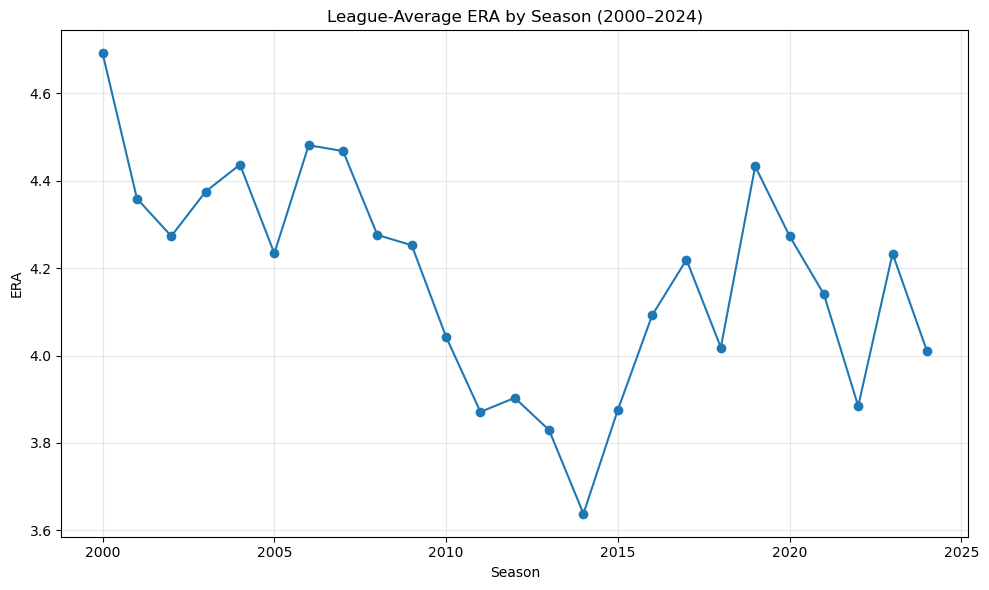

In [12]:
# League-average ERA by season
era_by_season = (
    pitching.groupby("yearID")["ERA"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,6))
plt.plot(era_by_season["yearID"], era_by_season["ERA"], marker="o", linestyle="-")
plt.title("League-Average ERA by Season (2000–2024)")
plt.xlabel("Season")
plt.ylabel("ERA")
plt.grid(alpha=0.3)
plt.tight_layout()

# Save before show
plt.savefig("../visuals/era_by_season.png", dpi=300)
plt.show()


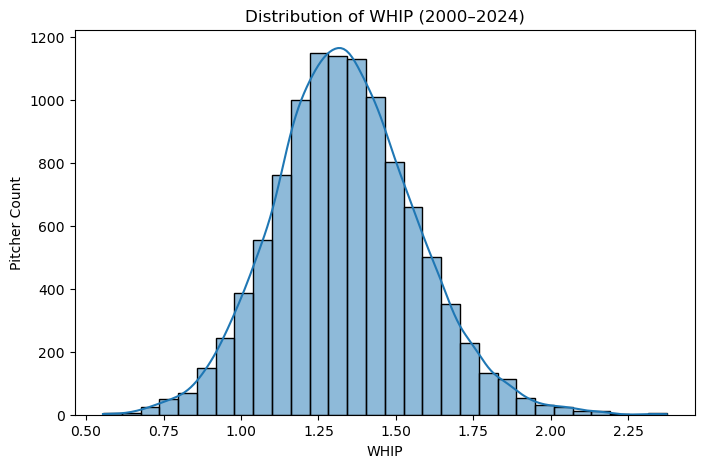

In [9]:
# Distribution of WHIP across all pitchers
plt.figure(figsize=(8,5))
sns.histplot(pitching["WHIP"], bins=30, kde=True)
plt.title("Distribution of WHIP (2000–2024)")
plt.xlabel("WHIP")
plt.ylabel("Pitcher Count")
plt.savefig("../visuals/whip_dist.png", dpi=300, bbox_inches="tight")
plt.show()

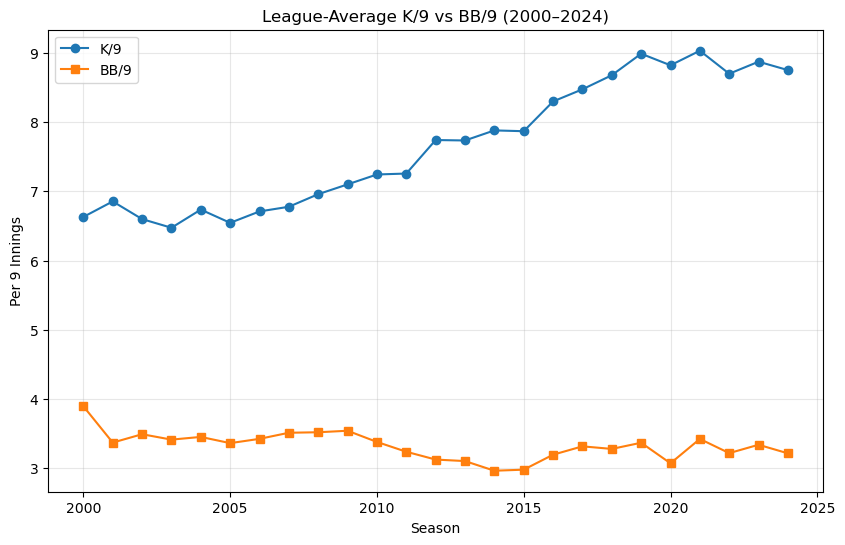

In [10]:
# League-average K/9 and BB/9 by season
league_trends = (
    pitching.groupby("yearID")
    .agg({"K_per9": "mean", "BB_per9": "mean"})
    .reset_index()
)

plt.figure(figsize=(10,6))
plt.plot(league_trends["yearID"], league_trends["K_per9"], marker="o", label="K/9")
plt.plot(league_trends["yearID"], league_trends["BB_per9"], marker="s", label="BB/9")

plt.title("League-Average K/9 vs BB/9 (2000–2024)")
plt.xlabel("Season")
plt.ylabel("Per 9 Innings")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("../visuals/k9_vs_bb9.png", dpi=300, bbox_inches="tight")
plt.show()

## 6. Visualization Prep (Tableau)

The cleaned dataset is exported to CSV for use in Tableau dashboards.  
Example visualizations include:
- Yearly league averages (K/9, BB/9, HR/9, WHIP)  
- Comparisons of elite pitchers vs. league average  
- Trends by team or decade  

## 7. Documentation

### Project Purpose
Analyze MLB pitching performance from 2000–2024 using Lahman data.  
Demonstrate full analytics workflow: data cleaning, feature engineering, SQL integration, analysis, and visualization prep.

### Data Sources
- **Lahman Database** (CSV format)  
- `Pitching.csv` → pitching stats  
- `People.csv` → player names  

### Methodology
1. Data cleaning (2000–2024, IPouts → IP, ≥30 IP filter)  
2. Feature engineering (K/9, BB/9, HR/9, WHIP)  
3. Database integration (SQLite)  
4. Exploratory analysis (Python)  
5. Visualization prep (Tableau-ready CSV)  

### Tools & Skills Demonstrated
- Python (Pandas, Numpy, Seaborn, Matplotlib)  
- SQL (SQLite)  
- Data cleaning & feature engineering  
- Visualization (Python + Tableau)  
- Reproducibility & workflow documentation  

### How to Reproduce
1. Place Lahman dataset in `data/lahman_data/`  
2. Run notebook cells in order  
3. Output saved to `data/cleaned_data/pitching_clean.csv`  
4. Import into Tableau for dashboards  

## Future Work

While this project has focused on pitching performance, my long-term goal is to expand the analysis into a more comprehensive, team-level and player-level evaluation tool. This will include hitting, fielding, and situational stats, allowing for an all-around baseball analysis. By building filters for team, player, and season, users will be able to drill down into both specific and comparative insights (e.g., “How do the 2024 Brewers’ pitchers compare to league-average hitters?”).  

The integration of batting and fielding stats, combined with interactive dashboards, would make this project more valuable for scouts, analysts, or fans who want a complete picture of team strengths and weaknesses.

## Conclusion

This project prepared and analyzed a cleaned MLB pitching dataset from 2000–2024.  

Key takeaways:
- Strikeouts per 9 innings have steadily increased across the league, reflecting the modern emphasis on velocity and swing-and-miss pitching.  
- WHIP distributions highlight the separation between elite pitchers and league-average performance.  
- SQL integration and Tableau prep demonstrate flexibility in using multiple tools for analysis.  

Future work could extend into predictive modeling and Statcast-based deep dives, bridging traditional baseball stats with advanced analytics.
